## Initial Definitions and Thoughts

**Anomolous Activity**: At least 500 total people on the trail in the past hour
- Corresponds to "BGT North of NE 70th Total" > 500

**Goal**: Forecast anomolous activity 3 hours into the future
- Corresponds to a multi-step time series forecast

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

## Data Loading and Inspection

In [2]:
# Load in data
df = pd.read_csv('burke-gilman-trail-north-of-ne-70th-st-bike-and-ped-counter (2).csv')

In [3]:
df.head(5)

,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South
0,2014-01-01T00:00:00.000,15.0,0.0,2.0,2.0,11.0
1,2014-01-01T01:00:00.000,9.0,1.0,0.0,1.0,7.0
2,2014-01-01T02:00:00.000,9.0,0.0,0.0,0.0,9.0
3,2014-01-01T03:00:00.000,19.0,0.0,0.0,0.0,19.0
4,2014-01-01T04:00:00.000,19.0,0.0,0.0,0.0,19.0


In [4]:
# Missing data present - for sake of time we will use simple imputation methods such as imputing with mean
# We do not want to drop the observation as we could lose the relationship between the previous observation and the next
df.isna().sum()

Date                             0
BGT North of NE 70th Total    2335
Ped South                     2335
Ped North                     2335
Bike North                    2335
Bike South                    2335
dtype: int64

In [5]:
df.dtypes

Date                           object
BGT North of NE 70th Total    float64
Ped South                     float64
Ped North                     float64
Bike North                    float64
Bike South                    float64
dtype: object

In [6]:
df.shape

(52584, 6)

In [7]:
# fairly sparse data
len(df[(df['Ped South'] == 0) | (df['Ped North'] == 0) | (df['Bike North'] == 0) | (df['Bike South'] == 0)]) / len(df)

0.3899094781682641

In [8]:
len(df[df['BGT North of NE 70th Total']==0]) / len(df)

0.12692073634565648

## Data Preprocessing

In [9]:
# Convert Date to datetime object
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
# Impute missing values with mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df_impute = df.loc[:, df.columns != 'Date'] # only impute features with missing values
df_impute = pd.DataFrame(imputer.fit_transform(df_impute), columns = df_impute.columns.values.tolist())

In [11]:
final_df = df_impute.copy()
final_df['Date'] = df['Date']
# rename BGT North since it's alot of typing
final_df.rename(columns={'BGT North of NE 70th Total' : 'BGT'}, inplace=True)
final_df = final_df[['Date', 'BGT', 'Ped South', 'Ped North', 'Bike South', 'Bike North']]

In [12]:
final_df.isnull().sum()

Date          0
BGT           0
Ped South     0
Ped North     0
Bike South    0
Bike North    0
dtype: int64

In [13]:
final_df.dtypes

Date          datetime64[ns]
BGT                  float64
Ped South            float64
Ped North            float64
Bike South           float64
Bike North           float64
dtype: object

In [14]:
# Preprocessing Complete!
final_df.head(5)

,Date,BGT,Ped South,Ped North,Bike South,Bike North
0,2014-01-01 00:00:00,15.0,0.0,2.0,11.0,2.0
1,2014-01-01 01:00:00,9.0,1.0,0.0,7.0,1.0
2,2014-01-01 02:00:00,9.0,0.0,0.0,9.0,0.0
3,2014-01-01 03:00:00,19.0,0.0,0.0,19.0,0.0
4,2014-01-01 04:00:00,19.0,0.0,0.0,19.0,0.0


## Data Visualization

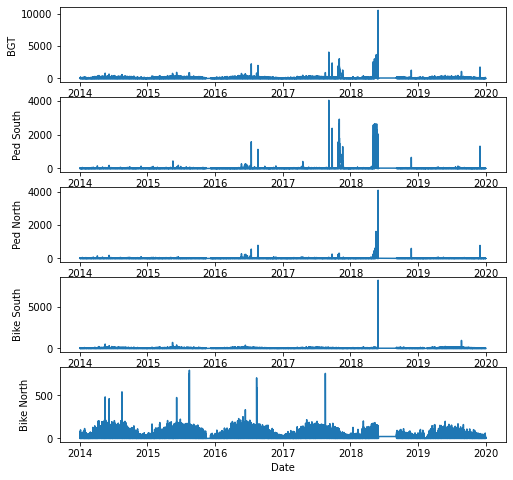

In [15]:
# strong seasonality especially in Bike North
# BGT will contain the additive trends and seasonalities of the other features since it is the total sum
fig, ax = plt.subplots(len(final_df.columns[1:]), figsize = (8,8))
for idx, feature in enumerate(final_df.columns[1:]):
    sns.lineplot(x='Date', y=feature, data=final_df, ax = ax[idx])

# As we can see, several noticable spikes in the total traffic on the path
# These spikes likely come from local events that drew in additional traffic
# Also note: The scales for each graph are a little different
# Due to the outliers, Bike North appears to have more volume of traffic than other features
# However, the outlier spikes shrink other data points for other features
# We can treat this in a quick and dirty way by capping the outliers
# I will use the standard deviation rule - it makes the assumption that the underlying data is normal
# Which is likely not the case, but I believe it will suffice for graphing purposes

In [16]:
def std_dev(data):
    return 2*math.sqrt(np.var(data))

In [17]:
df_plot = final_df.copy()
for feature in df_plot.columns[1:]:
    vals = df_plot[feature].values
    mu = np.mean(vals)
    two_sigma = std_dev(vals)
    upper = mu + two_sigma
    lower = mu - two_sigma

    def cap(x):
        if x > upper:
            x = upper
        if x < lower:
            x = lower
        return x

    df_plot[feature] = df_plot[feature].apply(lambda x : cap(x))

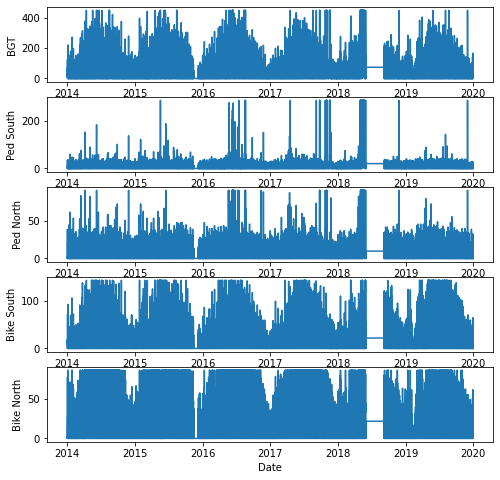

In [18]:
# Better!
# Clear seasonality with each feature, and the period appears to be one year
# This makes sense, as for example during the winter people are probably less likely to be on the path
# We could do statistical tests to verify this, but I don't
# recall the implementation and don't want to waste time researching it so I will just use visual inspection here

# Furthermore, the time of day is also important, as more people are likely to be on the path during the day
# than at night
fig, ax = plt.subplots(len(df_plot.columns[1:]), figsize = (8,8))
for idx, feature in enumerate(df_plot.columns[1:]):
    sns.lineplot(x='Date', y=feature, data=df_plot, ax = ax[idx])

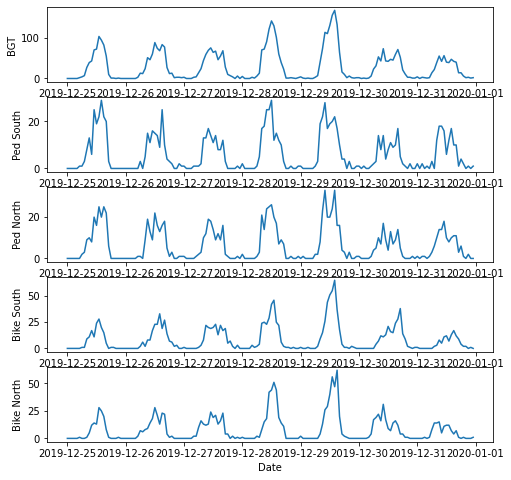

In [19]:
# We can also plot the past 7 or so days
# clear seasonal pattern each day as well! (7 peaks followed by a valley)

df_plot_week = df_plot.iloc[len(df_plot)-7*24:, :]
fig, ax = plt.subplots(len(df_plot_week.columns[1:]), figsize = (8,8))
for idx, feature in enumerate(df_plot_week.columns[1:]):
    sns.lineplot(x='Date', y=feature, data=df_plot_week, ax = ax[idx])

Above we observed the seasonality of the dataset. There is also likely a trend component as well as the population of seattle has likely increased during the time period of 2014 to 2019. This would mean more people using the path in addition to the seasonal patterns. I have excluded the analysis of trend for sake of time.

I can say from a visual inspection of the data, however, that there does not appear to be a significantly strong trend in the data.

## Feature Engineering

In [20]:
# Now with feature engineering, we have to think about what our response is
# Per the project specifications, we want to predict anomalies 3 hours into the future while using the features
# we are given

# Had we not been given a definition of an anomaly, this would have been an unsupervised learning problem
# However, we know that an anomaly is defined as BGT >= 500

# One approach is to treat this as a standard multivariate time series problem
# where our response is BGT and all other components are our features
# One thing I am somewhat concerned with this approach is that BGT is composed of all other features in a very
# simple way: an additive relationship.

# Therefore, I will use North Ped/Bike and South Ped/Bike to construct a new feature that hopefully won't
# give too much away about our response.

# Furthermore, if we want to base recommendations on whether to place the booth North/South, BGT response
# will not provide useful information as BGT does not give info on where exactly the traffic is coming from
# One potential solution for this is to run multiple time series forecasting models in tandem on each
# separate feature and sum their forecasts together and check if an anomoly occurred. Then check which direction
# has more traffic and place the business there

# There may also be some clever feature engineering, such as taking the difference between all north and south
# traffic, and checking which side has more favor, and multiply this number by an indicator variable
# that = 1 when BGT >= 500 and 0 o.w.

# However, I will stick to the original scope of the project, which is to simply forecast whether an anomaly will
# occur in the next 3 hours given the features at hand (e.g. if BGT > 500)

# In terms of new features, I will add an indicator variable to highlight whether or not an entry was anomalous
# Reason: Hopefully provide more context to the model of what an outlier means based on the definition

# I will also construct a "net difference" for the total traffic going north and south
# Reason: Contextualizes the direction of how traffic is flowing

In [21]:
# model df will include new features as well as a scaler that will place all values in a similar value range
model_df = final_df.copy()

In [22]:
# New Feature 1 : Indicator for Anomaly
# Anomaly defined as BGT >= 500
model_df['Anomalous'] = model_df['BGT'].apply(lambda x : 1 if x >= 500 else 0)

In [23]:
# Very few anamolous hours
# If we were to set this up as a classification problem, we would have to handle class imbalance
# However, I will continue onward with the traditional approach of forecasting BGT
len(model_df[model_df['Anomalous']==1]) / len(model_df)

0.009432527004411988

In [24]:
# New Feature 2 : Traffic Flow Difference
# Define as total North traffic - total South traffic
# So positive values will have stronger North traiffc and negative values with have stronger South traffic
model_df['Net Flow'] = model_df.apply(lambda row : row['Ped North'] - row['Ped South'] + row['Bike North'] - row['Bike South'], axis=1)

In [25]:
# now select newly engineered features and response
model_df = model_df[['Date', 'BGT', 'Anomalous', 'Net Flow']]

In [26]:
# These shall be the features I move forward with
# Potential additional features: lagged versions of BGT
model_df.head(5)

,Date,BGT,Anomalous,Net Flow
0,2014-01-01 00:00:00,15.0,0,-7.0
1,2014-01-01 01:00:00,9.0,0,-7.0
2,2014-01-01 02:00:00,9.0,0,-9.0
3,2014-01-01 03:00:00,19.0,0,-19.0
4,2014-01-01 04:00:00,19.0,0,-19.0


## Model Building

In [27]:
# features to use in training
# We removed Bike/Ped South and North features to avoid data leakage in our response BTG
features = ['Anomalous', 'Net Flow']

In [28]:
# First we need to do some additional data prep
# Let's begin by differencing the data to remove the daily seasonality
def difference(data, lag=24):
    diff = np.zeros(len(data))
    for i in range(lag, len(data)):
        diff[i-1] = data[i] - data[i-lag]
    return diff

In [29]:
# only difference BGT since it is seasonal
#  NOTE: this differencing was causing issues when converting back to the original scale, so I'm commenting it out
# for the sake of interpretibility
#model_df['BGT'] = difference(model_df['BGT'].values)

In [30]:
# Another step is to scale the data
# We will also invert this later
scaled_features = ['BGT', 'Net Flow']
scaler = StandardScaler()
model_df[scaled_features] = scaler.fit_transform(model_df[scaled_features])

### Baseline model: Persistence Forecasting
To compare the model we will build, it's good to have a simple baseline model so that one can compare how well the model actually performs. We will use the persistence model, which simply uses the most recent observation as the forecast.

In [31]:
# 80/20 test split
split = int(0.80*len(model_df))
train_df, test_df = model_df.iloc[:split, :], model_df.iloc[split:, :]

In [32]:
# training forecast length
tfl = len(test_df)

In [33]:
RMSE = None
train_df_BGT = train_df['BGT']
test_df_BGT = test_df['BGT']

# walk-forward validation
hist = [train_df_BGT.iloc[-1]]
predictions = np.zeros(tfl)
for i in range(tfl):
    yhat = hist[-1] # persistence forecast: latest observation becomes our prediction
    predictions[i] = yhat
    # add current observation to historical data
    hist.append(test_df_BGT.iloc[i])
RMSE = mean_squared_error(test_df_BGT.values, predictions)

In [34]:
print("Baseline RMSE %f " % RMSE)

Baseline RMSE 0.041244 


### Random Forest Model
We will try a tried and true model in ML: Random Forest. Why? Because RF can easily handle multivariate time series output.

In [35]:
def rf_predict(train, test):
    x_train = train[features] # input features
    y_train = train['BGT'] # target/response
    x_test = test[features] # prediction input for timestep t + 1

    model = RandomForestRegressor() # simple RF regressor
    model.fit(x_train, y_train)
    yhat = model.predict(x_test)

    # one step forecast, take first entry
    return yhat[0]

In [36]:
# save last 3 entries for out of sample forecast
train_df = model_df.iloc[:-3]

In [37]:
# we will use 24 hours as the future forecast for training
# RF model fitting is much slower than just taking the last entry of an array, so I chose
# a much smaller test size than 80/20
hours = 24
hist = train_df.iloc[:-hours]
future = train_df.iloc[[-hours]]
ytest = train_df.iloc[-hours:]['BGT']
RMSE = None
predictions = np.zeros(hours)

In [38]:
# walk-forward validation
# expanding window
for i in range(1, hours):
    yhat = rf_predict(train=hist, test=future) # make prediction on training set
    predictions[i-1] = yhat # record prediction
    hist = train_df.iloc[:-hours + i] # update history to include current time step
    future = model_df.iloc[[-hours+i]] # move onto next test sample
RMSE = mean_squared_error(ytest, predictions)

In [39]:
# slightly more skilled than the baseline model
print("RF RMSE %f " % RMSE)

RF RMSE 0.036678 


## Results

<AxesSubplot:ylabel='BGT'>

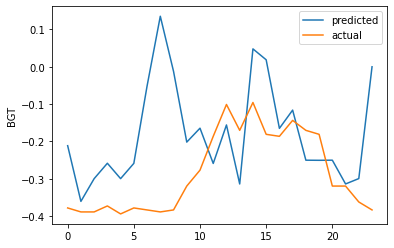

In [40]:
x = range(len(predictions))
sns.lineplot(x=x, y=predictions, label="predicted")
sns.lineplot(x=x, y=ytest, label="actual")

In [41]:
def rf_predict_multi(train, test):
    x_train = train[features] # input features
    y_train = train['BGT'] # target/response
    x_test = test[features] # prediction input for timestep t + 1

    model = RandomForestRegressor() # simple RF regressor
    model.fit(x_train, y_train)
    yhat = model.predict(x_test)

    # multi step forecast
    return yhat

In [42]:
# now let's make an "out of sample" prediction
y = rf_predict_multi(train_df, model_df.iloc[-3:])

In [43]:
# and convert it to the original scale and inverse the difference
# scaler took on shape of two, so our input needs to be the same
# let's just repeat the entries of our output
y_transform = np.repeat(y, 2).reshape(3,2)
y = scaler.inverse_transform(y_transform)[:,0]

In [44]:
# now create new data frame for plotting
future_hours = 3
last_timestamp = model_df['Date'].iloc[-1]
dates = list(pd.date_range(last_timestamp, periods=future_hours+1, freq='1h'))[1:]

In [45]:
pred_df = pd.DataFrame({'Date' : dates, 'BGT' : y})

In [46]:
full_df = pd.concat([final_df[['Date', 'BGT']], pred_df], ignore_index=True)

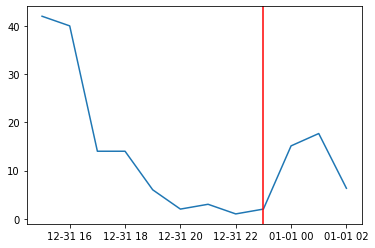

In [47]:
g = sns.lineplot(x=full_df['Date'].values[-12:], y=full_df['BGT'].values[-12:])
g.axvline(full_df['Date'].iloc[52583], color='r')

**Conclusion**: From the forecasted model results, we can conclude that there is evidence to suggest that no anomalous behavior will occur on the path for the next three hours. Therefore, it is recommended that the pop-up store finds another location besides the path for the time being.